=======================================================================================

Dataset Attributes

Input variables:

bank client data:

    age (numeric)
    job : type of job
    (categorical: 'admin.','bluecollar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    education (categorical:'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
    default: has credit in default? (categorical: 'no','yes')
    balance: it is a numerical column which indicate the client has how much outstanding balance in his account with the bank.
    housing: has housing loan? (categorical: 'no','yes')
    loan: has personal loan? (categorical: 'no','yes')

related with the last contact of the current campaign:

    contact: contact communication type (categorical: 'cellular','telephone', 'unknown')
    month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    day: last contact day of the month (numeric: 1,2,3....31)
    duration: last contact duration, in seconds (numeric). 

other attributes:

    campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    previous: number of contacts performed before this campaign and for this client (numeric)
    poutcome: outcome of the previous marketing campaign (categorical: 'failure','other','success', 'unknown')

Output variable (desired target):

    deposit: has the client subscribed a term deposit? (binary: 'yes','no')
=============================================================================


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas import plotting
%matplotlib inline
from time import time

In [2]:
# Import ml libraries
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc, log_loss, accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder() 
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# ignore all Deprecation warnings
simplefilter(action='ignore', category=DeprecationWarning)

## 1.Reading the data

In [3]:
# import data

url = 'https://raw.githubusercontent.com/ghoshrudy/ODSC-Response-model-workshop/master/bank.csv' ## url where the data is stored on github

df = pd.read_csv(url)

# assign data name

dataname=df

y='deposit' ## Target variable


## 2.Get data overview

In [4]:
# check shape
print("Train rows and columns : ", dataname.shape)

Train rows and columns :  (11162, 17)


In [5]:
# check column types

ctype = dataname.dtypes.reset_index()
ctype.columns = ["Count", "Column Type"]
print(ctype.groupby("Column Type").aggregate('count').reset_index())

print('----------------------')
dataname.info()

  Column Type  Count
0       int64      7
1      object     10
----------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
age          11162 non-null int64
job          11162 non-null object
marital      11162 non-null object
education    11162 non-null object
default      11162 non-null object
balance      11162 non-null int64
housing      11162 non-null object
loan         11162 non-null object
contact      11162 non-null object
day          11162 non-null int64
month        11162 non-null object
duration     11162 non-null int64
campaign     11162 non-null int64
pdays        11162 non-null int64
previous     11162 non-null int64
poutcome     11162 non-null object
deposit      11162 non-null object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
# display data
print(dataname.shape)
dataname.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [7]:
#looking at categorical columns
categorical = dataname.select_dtypes(include=[np.object]).columns
categorical, len(categorical)

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'deposit'],
       dtype='object'), 10)

In [5]:
#looking at numeric columns
numerical = dataname.select_dtypes(include=[np.number]).columns
numerical, len(numerical)

(Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'),
 7)

In [9]:
# numerical data distribution
dataname.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [10]:
# categorical data distribution
dataname.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,11162,11162,11162,11162,11162,11162,11162,11162,11162,11162
unique,12,3,4,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2566,6351,5476,10994,5881,9702,8042,2824,8326,5873


## 3.Data Cleaning

3a. Imputing for missing data

In [11]:
# check missing values
dataname.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [12]:
# Drop variables with > 10% null values

null_count = dataname.isnull().sum(axis=0).sort_values(ascending=False)
null_count.head(30)
np.sum(null_count > 0.1 * dataname.shape[0])
missing = [feature for feature in dataname.columns if null_count[feature] > 0.1 * dataname.shape[0]]
dataname.drop(missing, axis=1, inplace=True)

In [13]:
dataname.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
deposit      object
dtype: object

In [14]:
# For rest of variables impute missing with mode in case of categorical variables and mean in case of numeric variables

for i in (dataname.drop([y], axis=1).columns):
    if(dataname[i].dtypes == 'object'):
        dataname[i] = dataname[i].fillna(dataname[i].mode()[0])
    else:
        dataname[i].fillna(dataname[i].mean(), inplace = True)

In [0]:
dataname.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit'],
      dtype='object')

3b. Checking and treating for outliers

In [15]:
for i in (dataname.drop([y], axis=1).columns):
    if(dataname[i].dtypes != 'object'):
        fmean = np.mean(dataname[i])
        fstd = np.std(dataname[i])
        dataname.ix[np.abs(dataname[i]-fmean) > (3*fstd), i] = fmean + (3*fstd)  # treat upper outliers
        dataname.ix[np.abs(dataname[i]-fmean) < -(3*fstd), i] = -(fmean + (3*fstd)) # treat lower outliers
    else:
        continue

3b. Removing constant Features

In [16]:
#finding features with constant values

values_count = dataname.nunique(dropna=False).sort_values()
np.sum(values_count == 1)

0

In [17]:
# noting features with constant values for removal
constants = [feature for feature in dataname.columns if values_count[feature] == 1]
dataname.drop(constants, axis=1, inplace=True)

3c. Converting categorical into numeric

In [18]:
## Converting the target variable to 0 & 1
dataname[y] = dataname[y].apply(lambda x:1 if x == 'yes' else 0)
dataname[y].value_counts()

0    5873
1    5289
Name: deposit, dtype: int64

## 4.EDA

4a. Univariate analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F3AF0B208>,
      dtype=object)

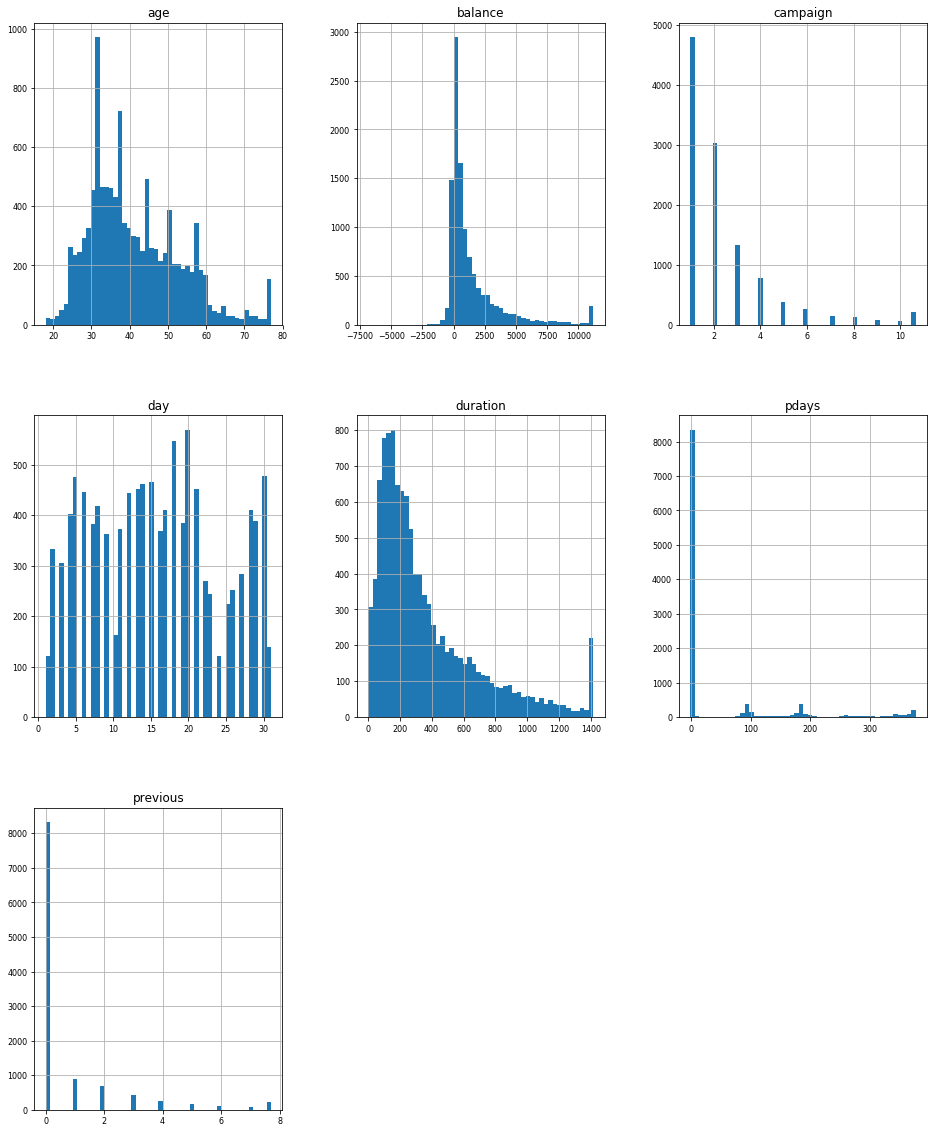

In [19]:
# histogram of numerical column
dataname[numerical].hist(figsize = (16,20), bins = 50, xlabelsize = 8, ylabelsize = 8)

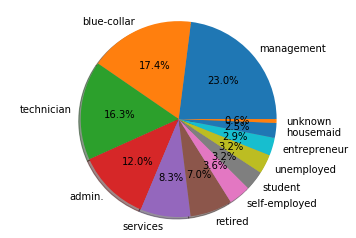

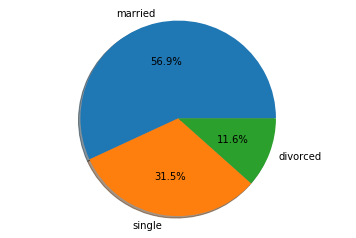

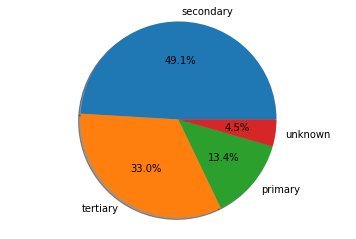

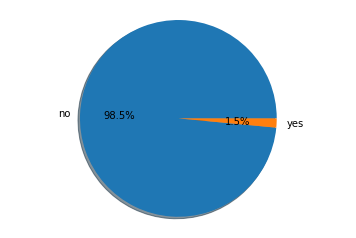

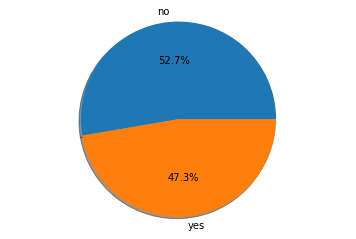

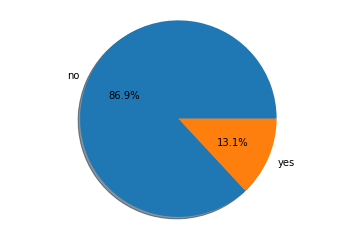

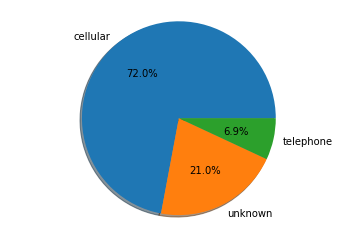

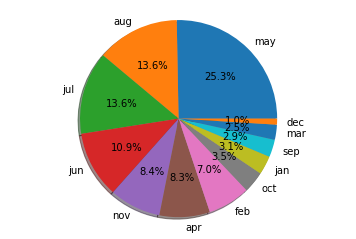

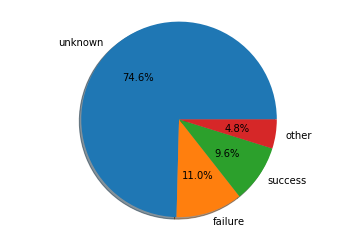

In [20]:
# charts of categorical column

# pie plot for categorical column

for i in (dataname.drop([y], axis=1).columns):
    if(dataname[i].dtypes == 'object'):       
        labels = np.array(dataname[i].value_counts().index)
        sizes = np.array(dataname[i].value_counts())
       
        fig1, ax1 = plt.subplots()
        ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
        ax1.axis('equal')

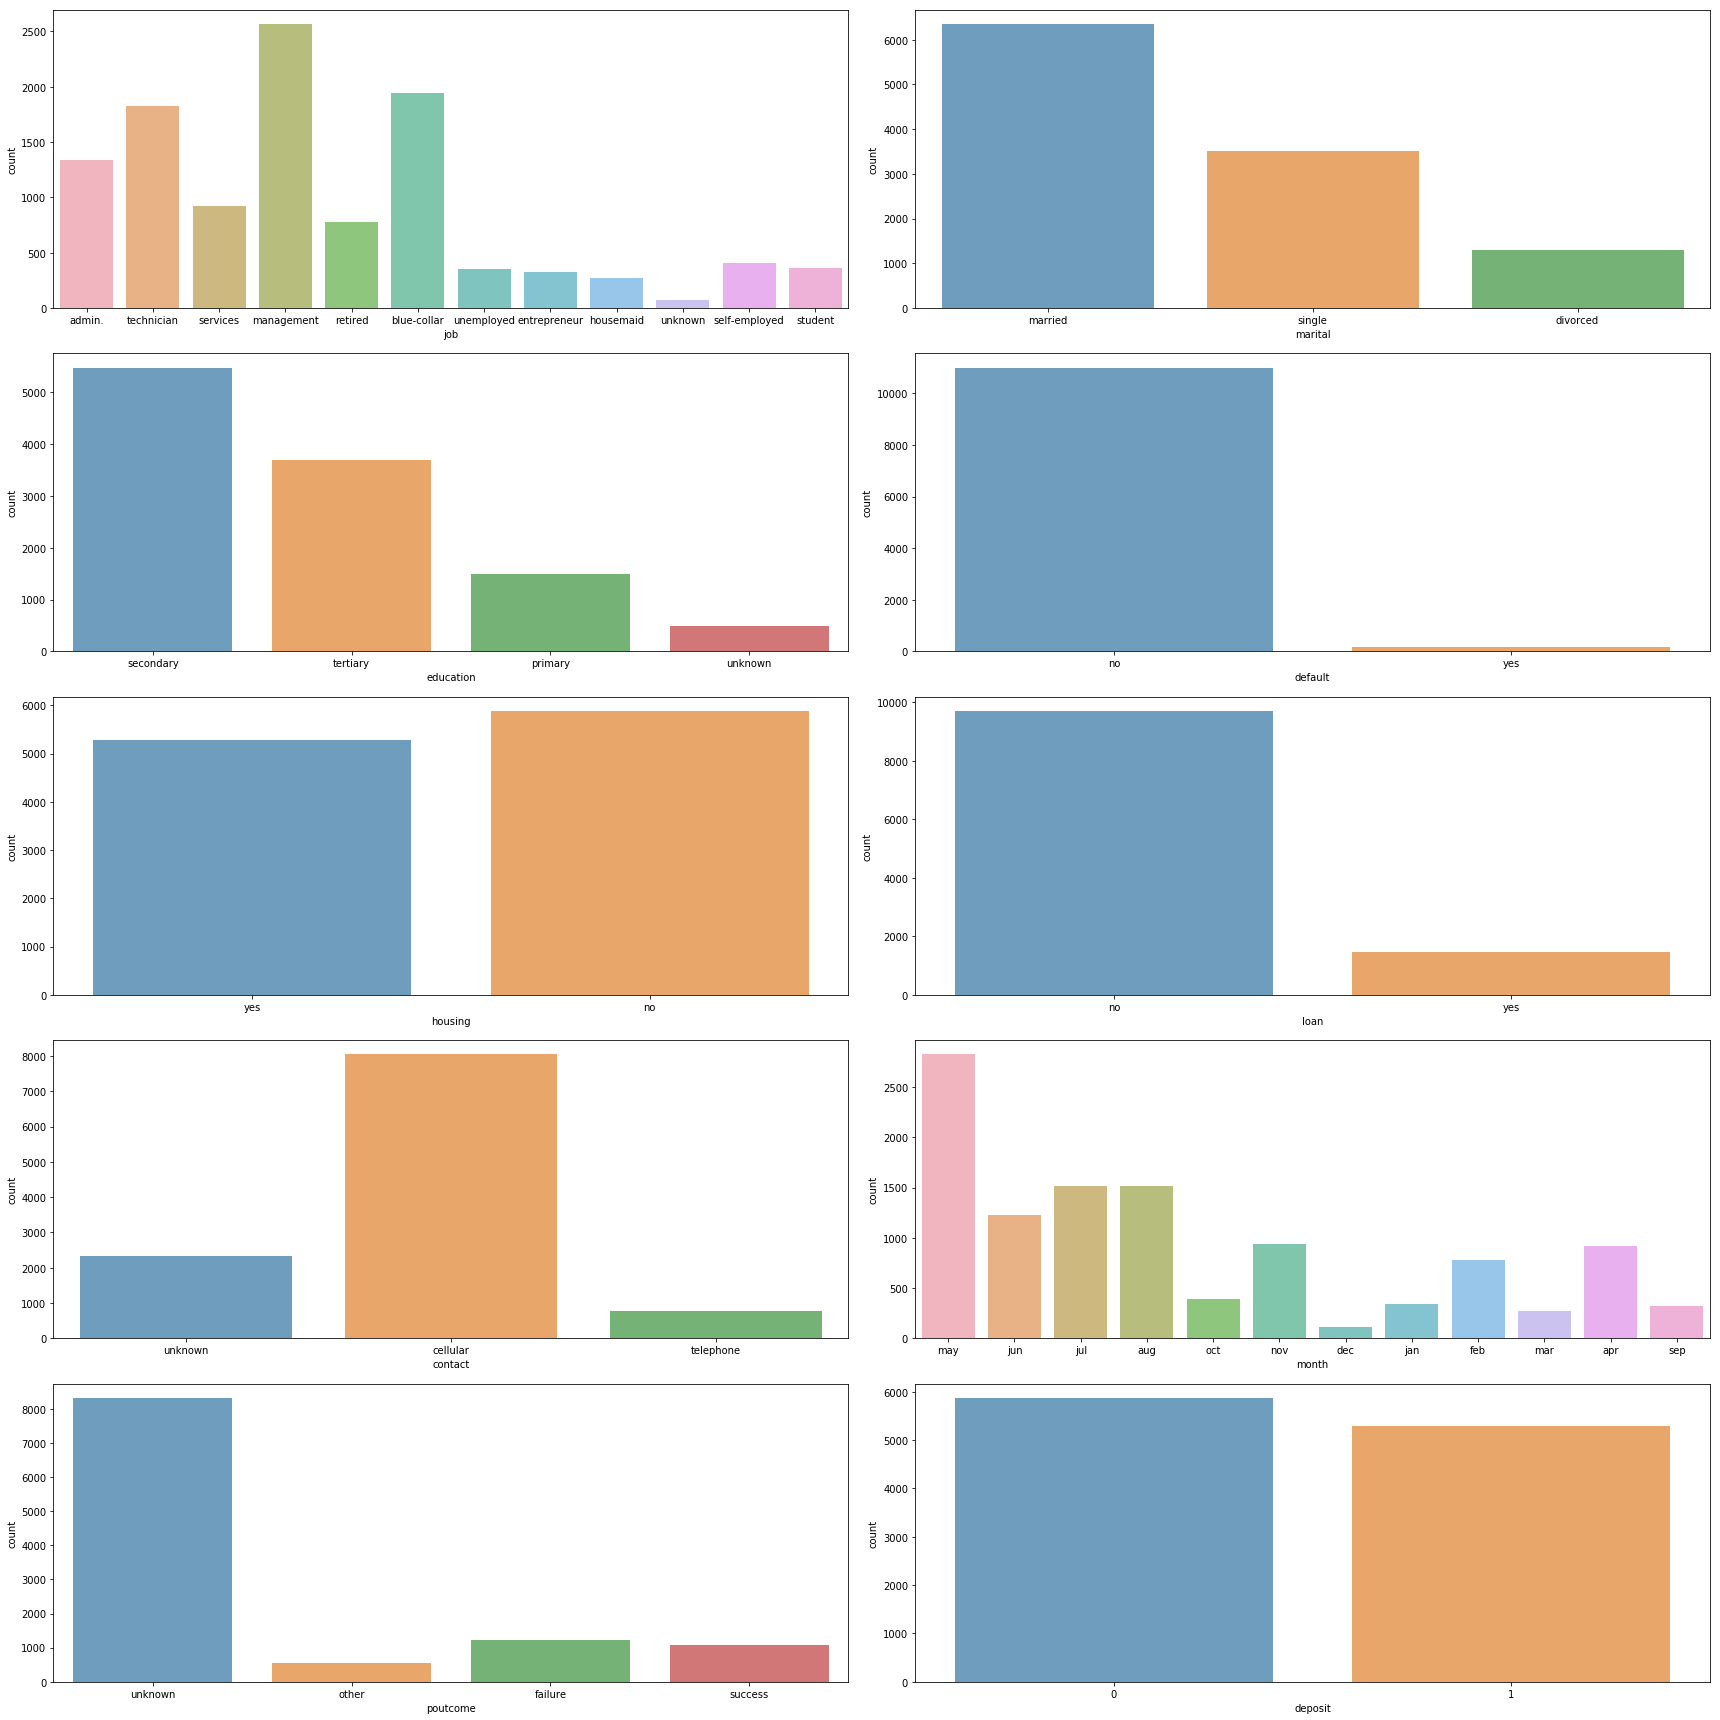

In [21]:
# bar plot for categorical column

df_cat = dataname[categorical]
fig, axes = plt.subplots(round(len(df_cat.columns)/2), 2, figsize=(24, 24))

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax)

fig.tight_layout()

4b. Bivariate analysis

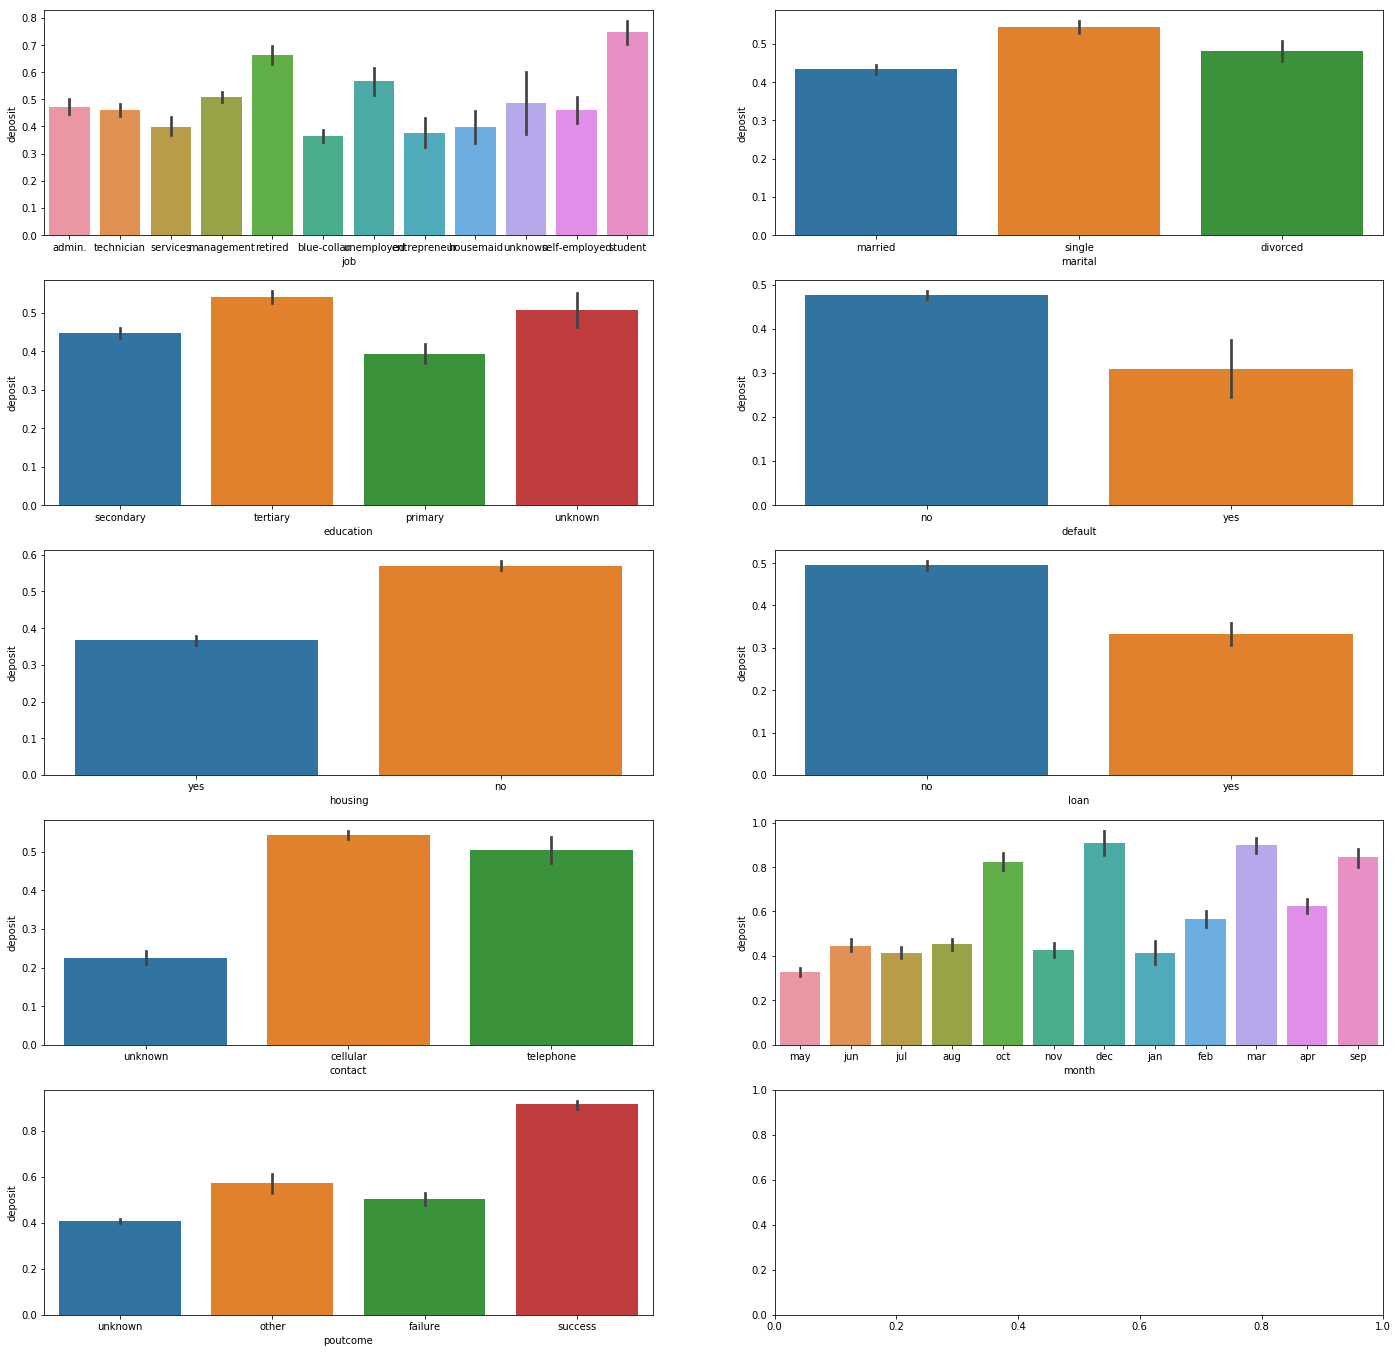

In [22]:
# categorical vs target variable

fig, axes = plt.subplots(round(len(categorical)/2), 2, figsize=(24, 24))

for i, ax in enumerate(fig.axes):
    if i < len(categorical)-1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
        sns.barplot(x=categorical[i], y=y, data=dataname[categorical], ax=ax)


C:\Users\Admin\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


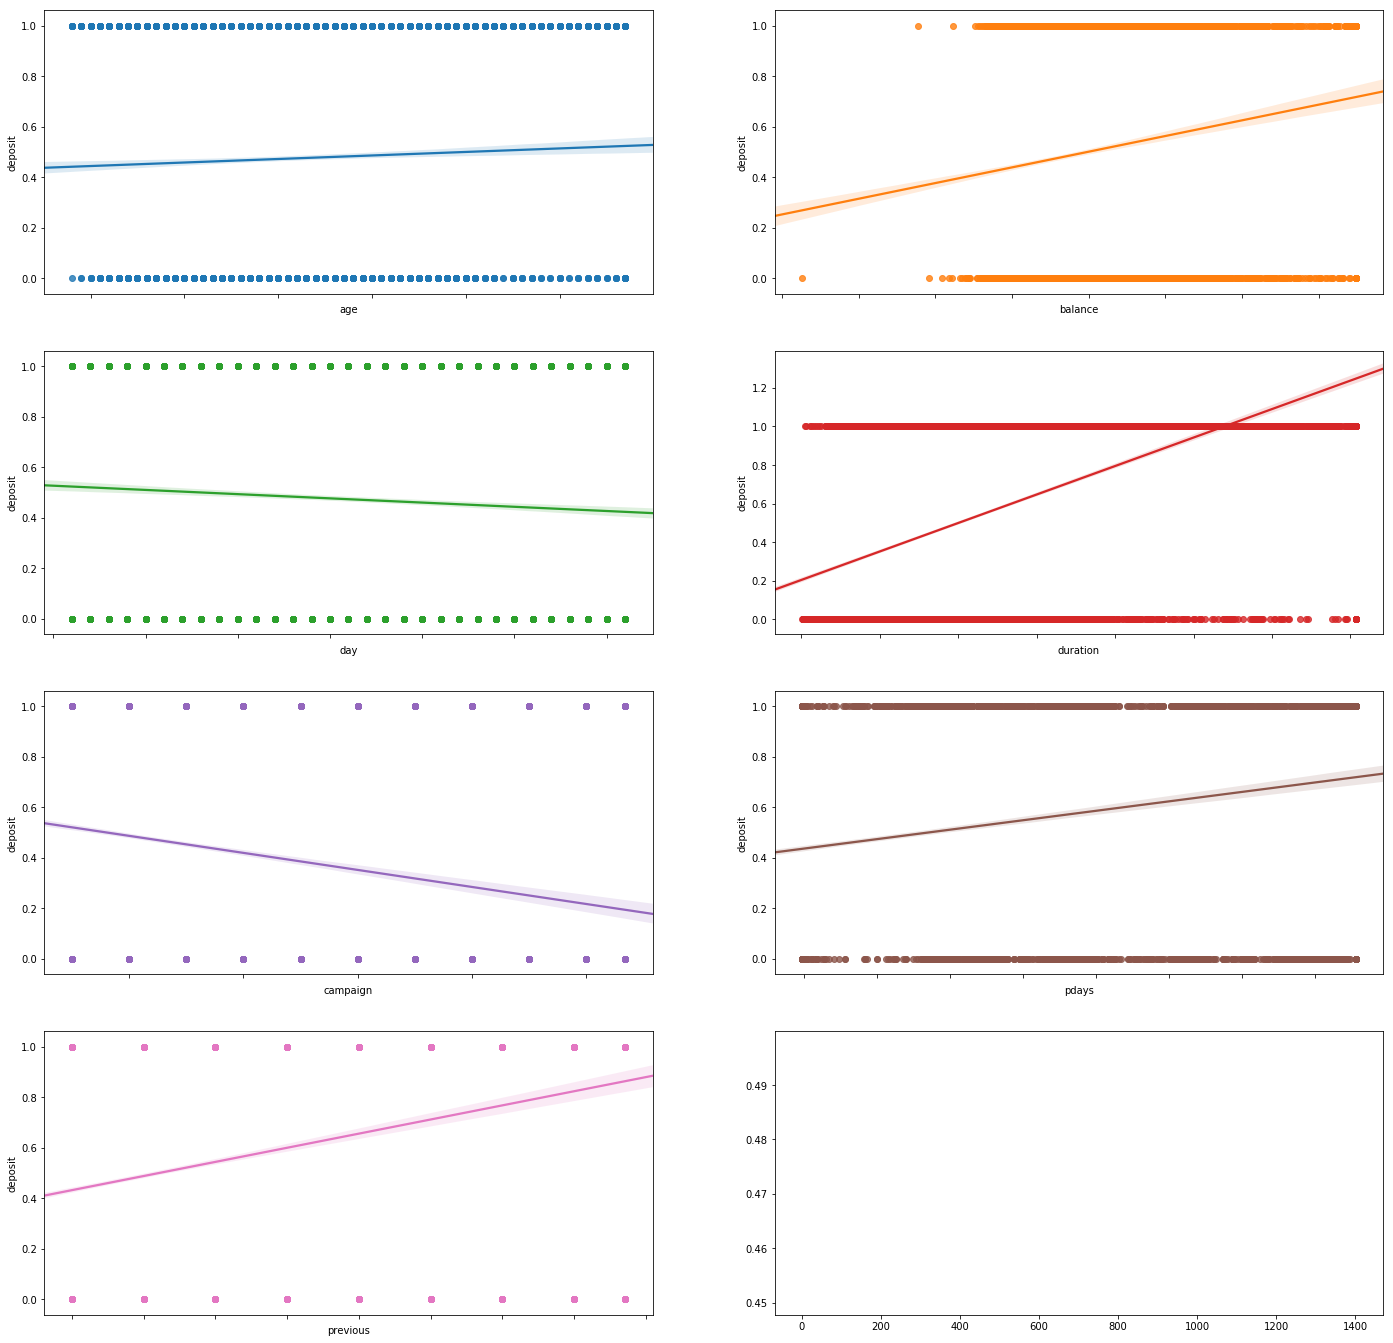

In [23]:
# numerical vs target variable
fig, axes = plt.subplots(round(len(numerical)/2), 2, figsize=(24, 24))

df_numeric = dataname[numerical]
df_numeric[y] = dataname.deposit

for i, ax in enumerate(fig.axes):
    if i < len(numerical):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
        sns.regplot(x=numerical[i], y=y, data=df_numeric, ax=ax)


4c. Multivariate analysis

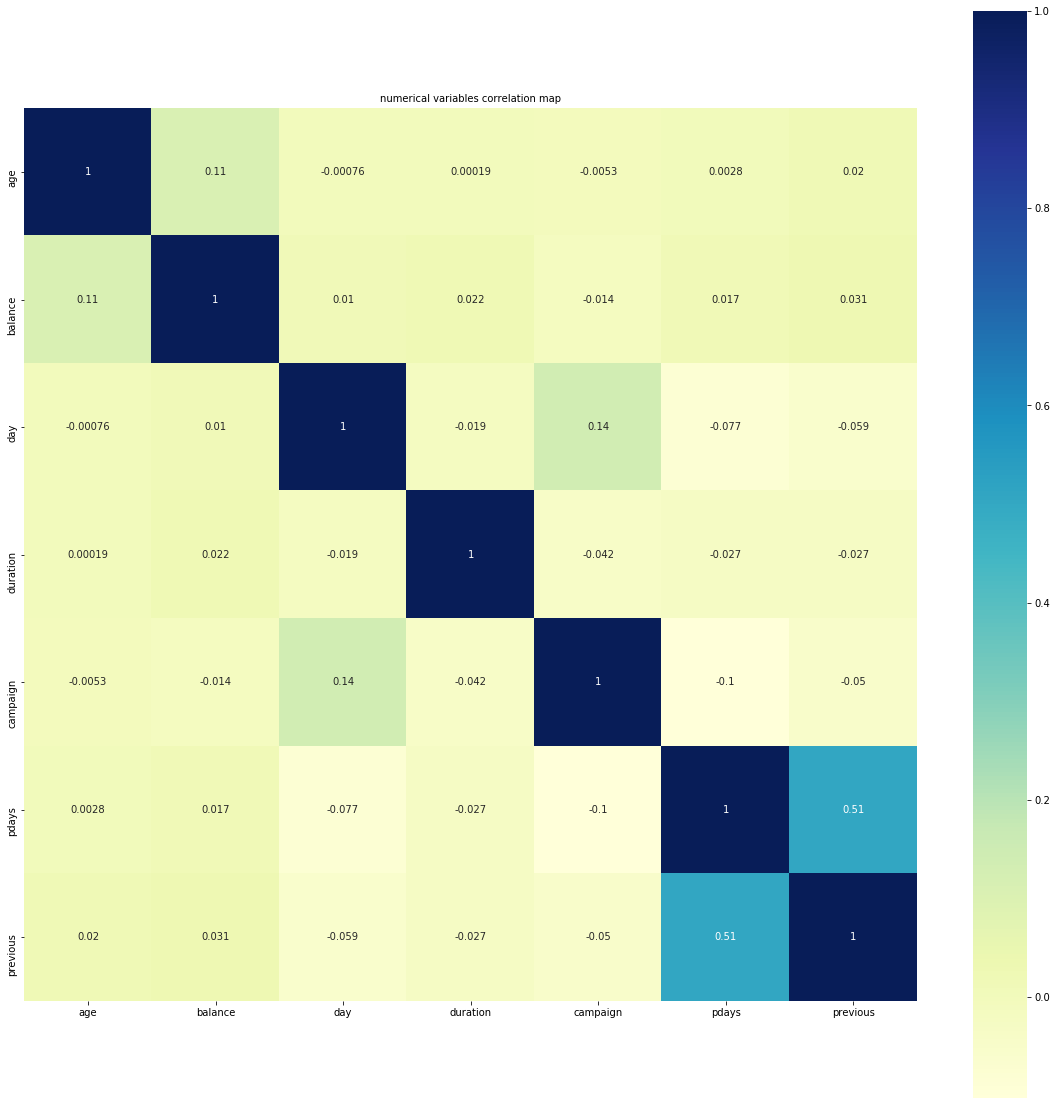

In [8]:
temp = dataname[numerical]
corrmat = temp.corr(method='pearson')
f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(corrmat, vmax=1., square=True, cmap="YlGnBu", annot=True)
plt.title("numerical variables correlation map", fontsize=10)
plt.show()

## Train test split

In [25]:
dataname_new = pd.get_dummies(dataname)
dataname_new.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'deposit', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataname_new.drop([y], axis=1),
                                                    dataname_new[y],
                                                    test_size = 0.25,
                                                    random_state = 0,
                                                    stratify = dataname_new[y]
                                                   )

print(X_train.shape)
print(X_test.shape)

(8371, 51)
(2791, 51)


# Feature selection

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X_train, y_train)
# summarize the selection of the attributes
print('Selected features: %s' % list(X_train.columns[rfe.support_]))

Selected features: ['job_retired', 'job_student', 'contact_unknown', 'month_dec', 'month_mar', 'month_oct', 'month_sep', 'poutcome_success']


## Function for running classification algorithm and getting required metrics

In [28]:
def algorithm_func(algorithm, x_train, y_train, x_test, y_test):
    classifier = algorithm
    classifier.fit(x_train,y_train)
    
    y_pred_proba_train = classifier.predict_proba(x_train)
    y_pred_train = classifier.predict(x_train)
    
    print('Train accuracy score:', accuracy_score(y_train, y_pred_train))
    print('Train Log-loss:', log_loss(y_train,y_pred_proba_train))
    print('Train precision:', precision_score(y_train, y_pred_train))
    print('Train recall:', recall_score(y_train, y_pred_train))
    cm_train = confusion_matrix(y_train, y_pred_train)
    
    
###############################################################################

    y_pred_proba_test = classifier.predict_proba(x_test)
    y_pred_test = classifier.predict(x_test)
    
    print('Test accuracy score:', accuracy_score(y_test, y_pred_test))
    print('Test Log-loss:', log_loss(y_test,y_pred_proba_test))
    print('Test precision:', precision_score(y_test, y_pred_test))
    print('Test recall:', recall_score(y_test, y_pred_test))
    
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    ## ROC curve
    
    fpr, tpr, threshold = roc_curve(y_test,y_pred_proba_test[:,1])
    print('auc:', auc(fpr,tpr))
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr,tpr))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Logistic Regression

Train accuracy score: 0.8310835025683909
Train Log-loss: 0.4038925752162983
Train precision: 0.8346002621231979
Train recall: 0.8026216284345853
Test accuracy score: 0.8212110354711573
Test Log-loss: 0.40938445099905946
Test precision: 0.822239624119029
Test recall: 0.794251134644478
auc: 0.9042233388156032


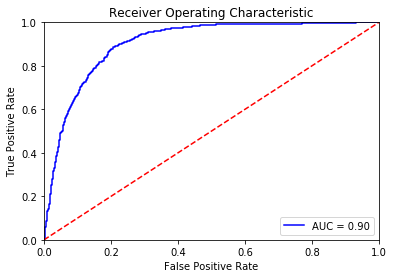

In [29]:
algorithm_func(LogisticRegression(C=1e5),
               X_train,
               y_train,
               X_test,
               y_test
              )

## Random Forest

Train accuracy score: 0.9900848166288376
Train Log-loss: 0.10975763635166894
Train precision: 0.992393509127789
Train recall: 0.9866397781699017
Test accuracy score: 0.8301683984235041
Test Log-loss: 0.7201767410977399
Test precision: 0.8271604938271605
Test recall: 0.81089258698941
auc: 0.9017182127045166


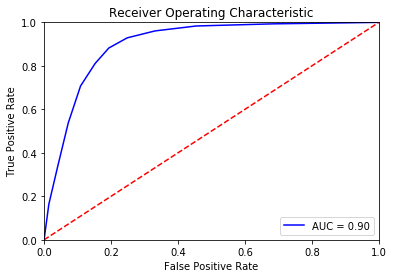

In [30]:
from sklearn.ensemble import RandomForestClassifier

algorithm_func(RandomForestClassifier(random_state = 0),
               X_train,
               y_train,
               X_test,
               y_test
              )

In [ ]:
# Exercise - Improve model performance 
# Either through trying a new technique
# Creation of derived features

## Hyperparameter Tuning

In [0]:
%%time
import random
random.seed(10)
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [3,4,5,6],
              'max_features': ['auto','sqrt', 'log2'],
              'min_samples_leaf': [3, 4, 5],
              'min_samples_split': [8, 10, 12],
              'n_estimators': [50, 100, 200, 300, 400]
             }

Classifier = RandomForestClassifier(random_state = 0)
model = GridSearchCV(Classifier, param_grid, cv = 5)
model.fit(X_train, y_train)
print(model.best_params_)


{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Wall time: 30min 30s


Train accuracy score: 0.8394457054115398
Train Log-loss: 0.4557553752657624
Train precision: 0.8274656679151061
Train recall: 0.8353919838669019
Test accuracy score: 0.8348262271587245
Test Log-loss: 0.46237544058750707
Test precision: 0.8210290827740492
Test recall: 0.8328290468986385
auc: 0.9066239344846443


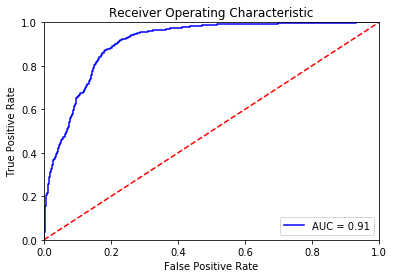

In [0]:
# algorithm_func(RandomForestClassifier(max_depth = model.best_params_['max_depth'],
#                                       max_features = model.best_params_['max_features'],
#                                       min_samples_leaf = model.best_params_['min_samples_leaf'],
#                                       min_samples_split = model.best_params_['min_samples_split'],
#                                       n_estimators = model.best_params_['n_estimators'],
#                                       random_state = 0),
#                X_train,
#                y_train,
#                X_test,
#                y_test
#               )

algorithm_func(RandomForestClassifier(max_depth = 6,
                                      max_features = 'auto',
                                      min_samples_leaf = 3,
                                      min_samples_split = 8,
                                      n_estimators = 100,
                                      random_state = 0),
               X_train,
               y_train,
               X_test,
               y_test
              )